In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import read_epochs, compute_rank, EvokedArray, set_log_level, concatenate_epochs
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne.decoding import UnsupervisedSpatialFilter

from scipy import signal, fft
from scipy.stats import gaussian_kde
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, LeaveOneOut

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
set_log_level('warning')
epochs = read_epochs('ica_epo.fif').pick('eeg')
epochs.drop_channels(epochs.info['bads'])

Number of events,65
Events,left: 14r_pinch: 11r_stop: 16rest: 13right: 11
Time range,-2.000 – 7.999 sec
Baseline,off


In [3]:
classes = ['left','rest']
subset = epochs[classes].copy()
subset.apply_baseline((-1.5,-0.1))

Number of events,27
Events,left: 14rest: 13
Time range,-2.000 – 7.999 sec
Baseline,-1.500 – -0.100 sec


Features

In [4]:
#temporal
def avg(x): 
    return np.average(x)

def avg_standarize(x, mean, std):
    return (x-mean)/std

def autocorr(x):
    return float(np.correlate(x,x))
    
def temp_centroid(x):
    nom = [x[i] * i for i in range(x.shape[0])]
    return sum(nom)/sum(x)

def mean_abs_diff(x):
    return np.mean(np.abs(np.diff(x)))

def median_abs_diff(x):
    return np.median(np.abs(np.diff(x)))

def slope(x):
    t = np.linspace(0, len(x)-1, len(x))
    return np.polyfit(t, x, 1)[0]

In [5]:
#spectral features utils
fs = 1024
def ff_transform(x):
    fmag = np.abs(np.fft.fft(x))
    f = np.linspace(0, fs//2, len(x)//2)
    return f[:len(x)//2].copy(), fmag[:len(x)//2].copy()

def filterbank(x, pre_emphasis=0.90, nfft=250, nfilt=8):
    emphasized_signal = np.append(np.array(x)[0], np.array(x[1:]) - pre_emphasis * np.array(x[:-1]))
    mag_frames = np.absolute(np.fft.rfft(emphasized_signal, nfft))  # Magnitude of the FFT
    pow_frames = ((1.0 / nfft) * (mag_frames ** 2))  # Power Spectrum
    low_freq_mel = 0
    high_freq_mel = (500 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10 ** (mel_points / 500) - 1))  # Convert Mel to Hz
    filter_bin = np.floor((nfft + 1) * hz_points / fs)

    fbank = np.zeros((nfilt, int(np.floor(nfft / 2 + 1))))
    for m in range(1, nfilt + 1):

        f_m_minus = int(filter_bin[m - 1])  # left
        f_m = int(filter_bin[m])  # center
        f_m_plus = int(filter_bin[m + 1])  # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - filter_bin[m - 1]) / (filter_bin[m] - filter_bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (filter_bin[m + 1] - k) / (filter_bin[m + 1] - filter_bin[m])

    # Area Normalization
    # If we don't normalize the noise will increase with frequency because of the filter width.
    enorm = 2.0 / (hz_points[2:nfilt + 2] - hz_points[:nfilt])
    fbank *= enorm[:, np.newaxis]

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB

    return filter_banks


In [6]:
#spectral
def spectral_distance(x):
    f, fmag = ff_transform(x)
    cum_fmag = np.cumsum(fmag)
    points_y = np.linspace(0, cum_fmag[-1], len(cum_fmag))
    return np.sum(points_y-cum_fmag)

def fft_mean_coeff(x, nfreq=3):
    fmag_mean = signal.spectrogram(x, fs, nperseg=nfreq*2 -2)[2].mean(1)
    return fmag_mean

def spectral_entropy(x):
    sig = x - np.mean(x)
    f, fmag = ff_transform(x)
    power = fmag **2
    if power.sum() == 0:
        return 0.0
    
    prob = np.divide(power, power.sum())
    prob = prob[prob != 0]
    
    return -np.multiply(prob, np.log2(prob)).sum() / np.log2(prob.size)

def mfcc(x, num_ceps=3, cep_lifter=11):
    filter_banks = filterbank(x)
    mel_coeff = fft.dct(filter_banks, type=2, axis=0, norm='ortho')[1:(num_ceps+1)]
    mel_coeff -= (np.mean(mel_coeff, axis=0) + 1e-8)
    #liftering
    ncoeff = len(mel_coeff)
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)  # cep_lifter = 22 from python_speech_features library

    mel_coeff *= lift

    return mel_coeff

def wavelet_abs_mean(x,  function= signal.ricker, widths=np.arange(1,4)):
    cwt = signal.cwt(x, function, widths)
    return np.abs(np.mean(cwt, axis=1))

def wavelet_std(x,  function= signal.ricker, widths=np.arange(1,4)):
    cwt = signal.cwt(x, function, widths)
    return np.std(cwt, axis=1)
    

In [7]:
lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
pca = PCA(n_components=0.8)
le = LabelEncoder()

Imagery vs Rest

In [14]:
fmax = 18
fmin = 7
time_config = (3,0.4,300,100)
csp_components = 2

In [15]:
#split training set
y = le.fit_transform(subset.events[:,2])
train_epochs = subset.get_data()
train_epochs, test_epochs, y_train, y_test = train_test_split(subset, y)
train_epochs = concatenate_epochs(train_epochs)
test_epochs = concatenate_epochs(test_epochs)

In [16]:
chance = np.mean(y_train == y_test[0])
chance = max(chance, 1. - chance)
val_chance = np.mean(y_test == y_test[0])
val_chance = max(val_chance, 1.-val_chance)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_9796\131910326.py:5: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = epochs.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()


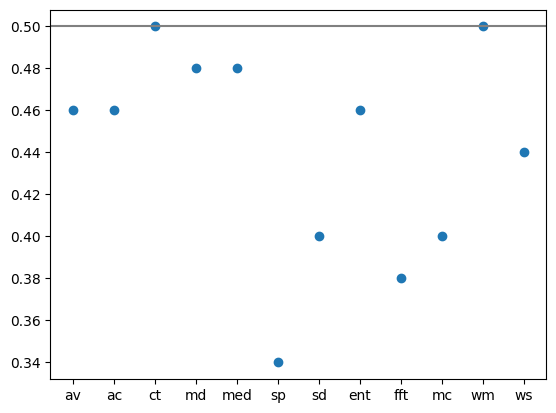

In [17]:
train_configuration(time_config, train_epochs, y_train, csp_components, fmax, fmin)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_9796\3619120377.py:10: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  x_train = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, verbose=None, n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9796\3619120377.py:11: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  x_test = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, verbose=None, n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9796\3619120377.py:10: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  x_train = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, verbose=None, n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9796\3619120377.py:1

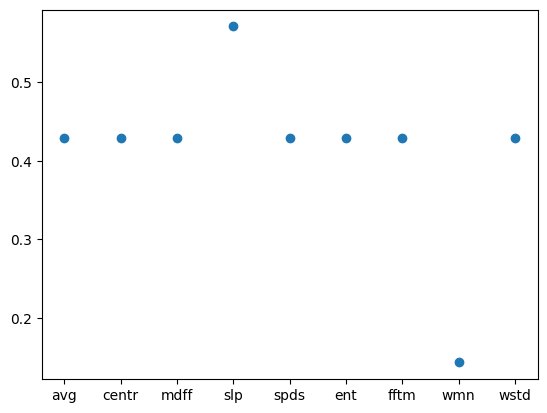

In [18]:
test_configuration(train_epochs, test_epochs, time_config, csp_components, fmax, fmin)

Left vs Right

In [24]:
classes = ['left','right']
subset = epochs[classes].copy()
subset.apply_baseline((-1.5,-0.1))
#split training set
y = le.fit_transform(subset.events[:,2])
train_epochs = subset.get_data()
train_epochs, test_epochs, y_train, y_test = train_test_split(subset, y)
train_epochs = concatenate_epochs(train_epochs)
test_epochs = concatenate_epochs(test_epochs)
chance = np.mean(y_train == y_test[0])
chance = max(chance, 1. - chance)

In [25]:
fmax = 60
fmin = 35
time_config = (3,0.4,300,100)
csp_components = 8
csp = CSP(n_components=csp_components, transform_into='csp_space')

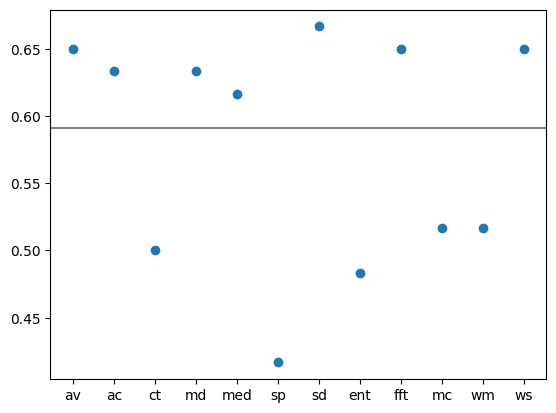

In [26]:
train_configuration(time_config, train_epochs, y_train, csp_components, fmax, fmin)

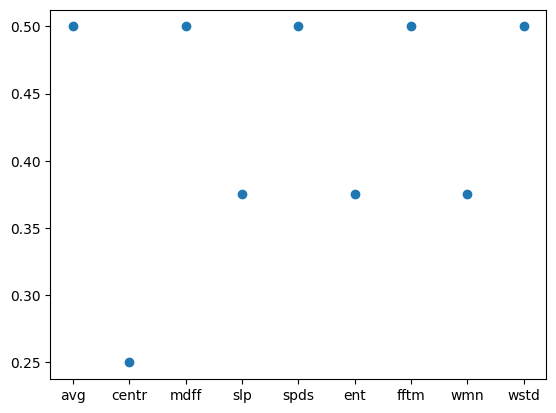

In [27]:
test_configuration(train_epochs, test_epochs, time_config, csp_components, fmax, fmin)

multiple feature vector

In [ ]:
test_multiple_features(['avg','centr',],time_config,csp_components,fmax,fmin,0.97)

In [12]:
def train_configuration(time_config, epochs, y_train, csp_components, fmax, fmin):
    features = 12
    n_windows, t_min, width, overlap = time_config
    csp = CSP(n_components=csp_components, transform_into='csp_space')
    test = epochs.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()

    best_acc = 0
    
    rep_score = []
    for rep in range(10):
        cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=21+rep)
        cv_split = cv.split(test)
        cv_scr = np.zeros((features,3))
        split = 0
        for train_idx, test_idx in cv_split:
            y_train_train, y_test_train = y_train[train_idx], y_train[test_idx]
            X_train = []
            X_test = []
            x_tr = test[train_idx]
            n_eps, n_chan, n_time = x_tr.shape
            csp.fit(x_tr,y_train_train)

            w_min = 0
            for i in range(n_windows):
                w_max = w_min + width
                x_tr = test[train_idx,:,w_min:w_max]
                n_eps, n_chan, n_time = x_tr.shape
                x_tr = csp.transform(x_tr)
                try:
                    avg_pwr =  np.apply_along_axis(avg, 2, x_tr**2)
                    avg_pwr = np.apply_along_axis(avg_standarize, 1, avg_pwr, mean=csp.mean_, std=csp.std_)
                    X_train[0] = np.concatenate([X_train[0], avg_pwr], axis=1)
                except:
                    avg_pwr =  np.apply_along_axis(avg, 2, x_tr**2)
                    avg_pwr = np.apply_along_axis(avg_standarize, 1, avg_pwr, mean=csp.mean_, std=csp.std_)
                    X_train.append(avg_pwr)
                try:
                    X_train[1] = np.concatenate([X_train[1], np.apply_along_axis(autocorr, 2, x_tr)], axis=1)
                except:
                    X_train.append(np.apply_along_axis(autocorr, 2, x_tr))
                try:
                    X_train[2] = np.concatenate([X_train[2], np.apply_along_axis(temp_centroid, 2, x_tr**2)], axis=1)
                except:
                    X_train.append(np.apply_along_axis(temp_centroid, 2, x_tr**2))
                try:
                    X_train[3] = np.concatenate([X_train[3], np.apply_along_axis(mean_abs_diff, 2, x_tr)], axis=1)
                except:
                    X_train.append(np.apply_along_axis(mean_abs_diff, 2, x_tr))
                try:
                    X_train[4] = np.concatenate([X_train[4], np.apply_along_axis(median_abs_diff, 2, x_tr)], axis=1)
                except:
                    X_train.append(np.apply_along_axis(median_abs_diff, 2, x_tr))
                try:
                    X_train[5] = np.concatenate([X_train[5], np.apply_along_axis(slope, 2, x_tr)], axis=1)
                except:
                    X_train.append(np.apply_along_axis(slope, 2, x_tr))
                try:
                    X_train[6] = np.concatenate([X_train[6], np.apply_along_axis(spectral_distance, 2, x_tr)], axis=1)
                except:
                    X_train.append(np.apply_along_axis(spectral_distance, 2, x_tr))
                try:
                    X_train[7] = np.concatenate([X_train[7], np.apply_along_axis(spectral_entropy, 2, x_tr)], axis=1)
                except:
                    X_train.append(np.apply_along_axis(spectral_entropy, 2, x_tr))
                #fft mean coefficient
                try:
                    X_train[8] = np.concatenate([X_train[8], 
                                                 np.apply_along_axis(
                                                     fft_mean_coeff, 2, 
                                                     x_tr,
                                                     nfreq= 2 if csp_components>7 else 4
                                                 )], axis=1)
                except:
                    X_train.append(np.apply_along_axis(
                        fft_mean_coeff, 2, 
                        x_tr,
                        nfreq= 2 if csp_components>7 else 4
                    ))
                #mel coeficcients
                try:
                    X_train[9] = np.concatenate([X_train[9], 
                                                 np.apply_along_axis(
                                                     mfcc, 2, 
                                                     x_tr,
                                                     num_ceps = 2 if csp_components>7 else 4
                                                 )], 
                                                axis=1)
                except:
                    X_train.append(np.apply_along_axis(mfcc, 2, 
                                                       x_tr,
                                                      num_ceps = 2 if csp_components>7 else 4
                                                      ))
                #wavelet abs mean
                try:
                    X_train[10] = np.concatenate([X_train[10], 
                                                  np.apply_along_axis(
                                                      wavelet_abs_mean, 2, 
                                                      x_tr,
                                                      widths = np.arange(1,3) if csp_components>7 else np.arange(1,5) 
                                                  )], 
                                                 axis=1)
                except:
                    X_train.append(np.apply_along_axis(
                            wavelet_abs_mean, 2, 
                            x_tr,
                            widths = np.arange(1,3) if csp_components>7 else np.arange(1,5) 
                    ))
                #wavelet std
                try:
                    X_train[11] = np.concatenate([X_train[11], 
                                                  np.apply_along_axis(
                                                      wavelet_std, 2, 
                                                      x_tr,
                                                      widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                                                  )], axis=1)
                except:
                    X_train.append(np.apply_along_axis(
                        wavelet_std, 2, 
                        x_tr,
                        widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                    ))


                #test
                x_tst = test[test_idx,:,w_min:w_max]
                n_eps, n_chan, n_time = x_tst.shape
                x_tst = csp.transform(x_tst)

                try:
                    avg_pwr =  np.apply_along_axis(avg, 2, x_tst**2)
                    avg_pwr = np.apply_along_axis(avg_standarize, 1, avg_pwr, mean=csp.mean_, std=csp.std_)
                    X_test[0] = np.concatenate([X_test[0], avg_pwr], axis=1)
                except:
                    avg_pwr =  np.apply_along_axis(avg, 2, x_tst**2)
                    avg_pwr = np.apply_along_axis(avg_standarize, 1, avg_pwr, mean=csp.mean_, std=csp.std_)
                    X_test.append(avg_pwr)
                try:
                    X_test[1] = np.concatenate([X_test[1], np.apply_along_axis(autocorr, 2, x_tst)], axis=1)
                except:
                    X_test.append(np.apply_along_axis(autocorr, 2, x_tst))
                try:
                    X_test[2] = np.concatenate([X_test[2], np.apply_along_axis(temp_centroid, 2, x_tst**2)], axis=1)
                except:
                    X_test.append(np.apply_along_axis(temp_centroid, 2, x_tst**2))
                try:
                    X_test[3] = np.concatenate([X_test[3], np.apply_along_axis(mean_abs_diff, 2, x_tst)], axis=1)
                except:
                    X_test.append(np.apply_along_axis(mean_abs_diff, 2, x_tst))
                try:
                    X_test[4] = np.concatenate([X_test[4], np.apply_along_axis(median_abs_diff, 2, x_tst)], axis=1)
                except:
                    X_test.append(np.apply_along_axis(median_abs_diff, 2, x_tst))
                try:
                    X_test[5] = np.concatenate([X_test[5], np.apply_along_axis(slope, 2, x_tst)], axis=1)
                except:
                    X_test.append(np.apply_along_axis(slope, 2, x_tst))
                try:
                    X_test[6] = np.concatenate([X_test[6], np.apply_along_axis(spectral_distance, 2, x_tst)], axis=1)
                except:
                    X_test.append(np.apply_along_axis(spectral_distance, 2, x_tst))
                try:
                    X_test[7] = np.concatenate([X_test[7], np.apply_along_axis(spectral_entropy, 2, x_tst)], axis=1)
                except:
                    X_test.append(np.apply_along_axis(spectral_entropy, 2, x_tst))
                #fft mean coefficient
                try:
                    X_test[8] = np.concatenate([X_test[8], 
                                                 np.apply_along_axis(
                                                     fft_mean_coeff, 2, 
                                                     x_tst,
                                                     nfreq= 2 if csp_components>7 else 4
                                                 )], axis=1)
                except:
                    X_test.append(np.apply_along_axis(
                        fft_mean_coeff, 2, 
                        x_tst,
                        nfreq= 2 if csp_components>7 else 4
                    ))
                #mel coeficcients
                try:
                    X_test[9] = np.concatenate([X_test[9], 
                                                 np.apply_along_axis(
                                                     mfcc, 2, 
                                                     x_tst,
                                                     num_ceps = 2 if csp_components>7 else 4
                                                 )], 
                                                axis=1)
                except:
                    X_test.append(np.apply_along_axis(mfcc, 2, 
                                                       x_tst,
                                                      num_ceps = 2 if csp_components>7 else 4
                                                      ))
                #wavelet abs mean
                try:
                    X_test[10] = np.concatenate([X_test[10], 
                                                  np.apply_along_axis(
                                                      wavelet_abs_mean, 2, 
                                                      x_tst,
                                                      widths = np.arange(1,3) if csp_components>7 else np.arange(1,5) 
                                                  )], 
                                                 axis=1)
                except:
                    X_test.append(np.apply_along_axis(
                            wavelet_abs_mean, 2, 
                            x_tst,
                            widths = np.arange(1,3) if csp_components>7 else np.arange(1,5) 
                    ))
                #wavelet std
                try:
                    X_test[11] = np.concatenate([X_test[11], 
                                                  np.apply_along_axis(
                                                      wavelet_std, 2, 
                                                      x_tst,
                                                      widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                                                  )], axis=1)
                except:
                    X_test.append(np.apply_along_axis(
                        wavelet_std, 2, 
                        x_tst,
                        widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                    ))

                w_min += w_max - overlap

            for ft in range(features):
                if ft > 7:
                    n_eps, n_fts, n_frq = X_train[ft].shape
                    x_trn = X_train[ft].reshape(n_eps, n_fts*n_frq)
                    n_eps, n_fts, n_frq = X_test[ft].shape
                    x_tst = X_test[ft].reshape(n_eps, n_fts*n_frq)
                else :
                    x_trn = X_train[ft]
                    x_tst = X_test[ft]
                #reduce dimensiontality
                if x_trn.shape[1] > 6: 
                    x_trn = pca.fit_transform(x_trn)
                    x_tst = pca.transform(x_tst)
                    
                lda.fit(x_trn,y_train_train)
                current_score = lda.score(x_tst, y_test_train)
                cv_scr[ft,split] = current_score
            split += 1    
        rep_score.append(np.median(cv_scr, axis=1))
    fig, axes= plt.subplots(1)
    x = np.array(list(range(12)))+1
    features = ['av','ac','ct','md','med','sp','sd','ent','fft','mc','wm','ws']
    axes.scatter(x, np.mean(rep_score, axis=0))
    axes.set_xticks(x)
    axes.axhline(chance, c='grey')
    axes.set_xticklabels(features)


In [13]:
def test_configuration(train_epochs, test_epochs, time_config, csp_components, fmax, fmin):
    scores = np.zeros(9)
    csp = CSP(n_components=csp_components, transform_into='csp_space')
    n_windows, t_min, width, overlap = time_config
    w_min = 0
    for i in range(n_windows):
        X_test = []
        X_train = []
        w_max = w_min + width
        x_train = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, verbose=None, n_jobs=4).get_data()
        x_test = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, verbose=None, n_jobs=4).get_data()

        x_train = csp.fit_transform(x_train, y_train)
        x_test = csp.transform(x_test)
        try:
            X_train[0] = np.concatenate([X_train[0], np.apply_along_axis(avg, 2, x_train**2)], axis=1)
        except:
            X_train.append(np.apply_along_axis(avg, 2, x_train**2))
        try:
            X_train[1] = np.concatenate([X_train[1], np.apply_along_axis(temp_centroid, 2, x_train**2)], axis=1)
        except:
            X_train.append(np.apply_along_axis(temp_centroid, 2, x_train**2))
        try:
            X_train[2] = np.concatenate([X_train[2], np.apply_along_axis(median_abs_diff, 2, x_train)], axis=1)
        except:
            X_train.append(np.apply_along_axis(median_abs_diff, 2, x_train))
        try:
            X_train[3] = np.concatenate([X_train[3], np.apply_along_axis(slope, 2, x_train)], axis=1)
        except:
            X_train.append(np.apply_along_axis(slope, 2, x_train))
        try:
            X_train[4] = np.concatenate([X_train[4], np.apply_along_axis(spectral_distance, 2, x_train)], axis=1)
        except:
            X_train.append(np.apply_along_axis(spectral_distance, 2, x_train))
        try:
            X_train[5] = np.concatenate([X_train[5], np.apply_along_axis(spectral_entropy, 2, x_train)], axis=1)
        except:
            X_train.append(np.apply_along_axis(spectral_entropy, 2, x_train))
        try:
            X_train[6] = np.concatenate([X_train[6], 
                                         np.apply_along_axis(
                                             fft_mean_coeff, 2, 
                                             x_train,
                                             nfreq= 2 if csp_components>7 else 4
                                         )], axis=1)
        except:
            X_train.append(np.apply_along_axis(
                fft_mean_coeff, 2, 
                x_train,
                nfreq= 2 if csp_components>7 else 4
            ))
        try:
            X_train[7] = np.concatenate([X_train[7], 
                                          np.apply_along_axis(
                                              wavelet_abs_mean, 2, 
                                              x_train,
                                              widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                                          )], axis=1)
        except:
            X_train.append(np.apply_along_axis(
                wavelet_abs_mean, 2, 
                x_train,
                widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
            ))
        try:
            X_train[8] = np.concatenate([X_train[8], 
                                          np.apply_along_axis(
                                              wavelet_std, 2, 
                                              x_train,
                                              widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                                          )], axis=1)
        except:
            X_train.append(np.apply_along_axis(
                wavelet_std, 2, 
                x_train,
                widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
            ))


        #test
        try:
            X_test[0] = np.concatenate([X_test[0], np.apply_along_axis(avg, 2, x_test**2)], axis=1)
        except:
            X_test.append(np.apply_along_axis(avg, 2, x_test**2))
        try:
            X_test[1] = np.concatenate([X_test[1], np.apply_along_axis(temp_centroid, 2, x_test**2)], axis=1)
        except:
            X_test.append(np.apply_along_axis(temp_centroid, 2, x_test**2))
        try:
            X_test[2] = np.concatenate([X_test[2], np.apply_along_axis(median_abs_diff, 2, x_test)], axis=1)
        except:
            X_test.append(np.apply_along_axis(median_abs_diff, 2, x_test))
        try:
            X_test[3] = np.concatenate([X_test[3], np.apply_along_axis(slope, 2, x_test)], axis=1)
        except:
            X_test.append(np.apply_along_axis(slope, 2, x_test))
        try:
            X_test[4] = np.concatenate([X_test[4], np.apply_along_axis(spectral_distance, 2, x_test)], axis=1)
        except:
            X_test.append(np.apply_along_axis(spectral_distance, 2, x_test))
        try:
            X_test[5] = np.concatenate([X_test[5], np.apply_along_axis(spectral_entropy, 2, x_test)], axis=1)
        except:
            X_test.append(np.apply_along_axis(spectral_entropy, 2, x_test))
        try:
            X_test[6] = np.concatenate([X_test[6], 
                                          np.apply_along_axis(
                                              fft_mean_coeff, 2, 
                                              x_test,
                                              nfreq= 2 if csp_components>7 else 4
                                          )], axis=1)
        except:
            X_test.append(np.apply_along_axis(
                fft_mean_coeff, 2, 
                x_test,
                nfreq= 2 if csp_components>7 else 4
            ))
        try:
            X_test[7] = np.concatenate([X_test[7], 
                                          np.apply_along_axis(
                                              wavelet_abs_mean, 2, 
                                              x_test,
                                              widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                                          )], axis=1)
        except:
            X_test.append(np.apply_along_axis(
                wavelet_abs_mean, 2, 
                x_test,
                widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
            ))
        try:
            X_test[8] = np.concatenate([X_test[8], 
                                      np.apply_along_axis(
                                          wavelet_std, 2, 
                                          x_test,
                                          widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                                      )], axis=1)
        except:
            X_test.append(np.apply_along_axis(
                wavelet_std, 2, 
                x_test,
                widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
            ))

        w_min += w_max - overlap

    for ft in range(len(scores)):
        if ft > 5:
            n_eps, n_fts, n_frq = X_train[ft].shape
            x_train = X_train[ft].reshape(n_eps, n_fts*n_frq)
            n_eps, n_fts, n_frq = X_test[ft].shape
            x_test = X_test[ft].reshape(n_eps, n_fts*n_frq)
        else :
            x_test = X_test[ft]
            x_train = X_train[ft]
        #reduce dimensiontality
        if x_train.shape[1] > 6: 
            x_train = pca.fit_transform(x_train)
            x_test = pca.transform(x_test)

        lda.fit(x_train,y_train)
        current_score = lda.score(x_test, y_test)
        scores[ft] = current_score
        
    fig, axes= plt.subplots(1)
    x = np.array(list(range(12)))+1
    features = ['avg','centr','mdff','slp','spds','ent','fftm','wmn','wstd']
    axes.scatter(features, scores)
#     axes.axhline(val_chance, c='grey')

In [ ]:
def test_multiple_features(proposed, time_config, csp_components, fmax, fmin, pca_var):
    pca = PCA(n_components=12)
    n_features = 12
    n_windows, t_min, width, overlap = time_config
    features = ['avg','centr','mdff','slp','spds','ent','fftm','wmn','wstd'] 
    proposed = np.isin(features,proposed)
    csp = CSP(n_components=csp_components, transform_into='csp_space')
    test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()

    cv_split = cv.split(test)

    cv_scr = []
    split = 0
    best_acc = 0
    for train_idx, test_idx in cv_split:
        y_train, y_test = y[train_idx], y[test_idx]
        X_train = []
        X_test = []
        x_tr = test[train_idx]
        n_eps, n_chan, n_time = x_tr.shape
        csp.fit(x_tr,y_train)
        w_min = 0
        for i in range(n_windows):
            w_max = w_min + width
            x_tr = test[train_idx,:,w_min:w_max]
            n_eps, n_chan, n_time = x_tr.shape
            x_tr = csp.transform(x_tr)
        try:
            X_train[0] = np.concatenate([X_train[0], np.apply_along_axis(avg, 2, x_tr**2)], axis=1)
        except:
            X_train.append(np.apply_along_axis(avg, 2, x_tr**2))
        try:
            X_train[1] = np.concatenate([X_train[1], np.apply_along_axis(temp_centroid, 2, x_tr**2)], axis=1)
        except:
            X_train.append(np.apply_along_axis(temp_centroid, 2, x_tr**2))
        try:
            X_train[2] = np.concatenate([X_train[2], np.apply_along_axis(mean_abs_diff, 2, x_tr)], axis=1)
        except:
            X_train.append(np.apply_along_axis(mean_abs_diff, 2, x_tr))
        try:
            X_train[3] = np.concatenate([X_train[3], np.apply_along_axis(slope, 2, x_tr)], axis=1)
        except:
            X_train.append(np.apply_along_axis(slope, 2, x_tr))
        try:
            X_train[4] = np.concatenate([X_train[4], np.apply_along_axis(spectral_distance, 2, x_tr)], axis=1)
        except:
            X_train.append(np.apply_along_axis(spectral_distance, 2, x_tr))
        try:
            X_train[5] = np.concatenate([X_train[5], np.apply_along_axis(spectral_entropy, 2, x_tr)], axis=1)
        except:
            X_train.append(np.apply_along_axis(spectral_entropy, 2, x_tr))
        try:
            X_train[6] = np.concatenate([X_train[6], 
                                         np.apply_along_axis(
                                             fft_mean_coeff, 2, 
                                             x_tr,
                                             nfreq= 2 if csp_components>7 else 4
                                         )], axis=1)
        except:
            X_train.append(np.apply_along_axis(
                fft_mean_coeff, 2, 
                x_tr,
                nfreq= 2 if csp_components>7 else 4
            ))
        try:
            X_train[7] = np.concatenate([X_train[7], 
                                          np.apply_along_axis(
                                              wavelet_abs_mean, 2, 
                                              x_tr,
                                              widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                                          )], axis=1)
        except:
            X_train.append(np.apply_along_axis(
                wavelet_abs_mean, 2, 
                x_tr,
                widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
            ))
        try:
            X_train[8] = np.concatenate([X_train[8], 
                                          np.apply_along_axis(
                                              wavelet_std, 2, 
                                              x_tr,
                                              widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                                          )], axis=1)
        except:
            X_train.append(np.apply_along_axis(
                wavelet_std, 2, 
                x_tr,
                widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
            ))

        x_tst = test[test_idx,:,w_min:w_max]
        n_eps, n_chan, n_time = x_tst.shape
        x_tst = csp.transform(x_tst)
        #test
        try:
            X_test[0] = np.concatenate([X_test[0], np.apply_along_axis(avg, 2, x_tst**2)], axis=1)
        except:
            X_test.append(np.apply_along_axis(avg, 2, x_tst**2))
        try:
            X_test[1] = np.concatenate([X_test[1], np.apply_along_axis(temp_centroid, 2, x_tst**2)], axis=1)
        except:
            X_test.append(np.apply_along_axis(temp_centroid, 2, x_tst**2))
        try:
            X_test[2] = np.concatenate([X_test[2], np.apply_along_axis(mean_abs_diff, 2, x_tst)], axis=1)
        except:
            X_test.append(np.apply_along_axis(mean_abs_diff, 2, x_tst))
        try:
            X_test[3] = np.concatenate([X_test[3], np.apply_along_axis(slope, 2, x_tst)], axis=1)
        except:
            X_test.append(np.apply_along_axis(slope, 2, x_tst))
        try:
            X_test[4] = np.concatenate([X_test[4], np.apply_along_axis(spectral_distance, 2, x_tst)], axis=1)
        except:
            X_test.append(np.apply_along_axis(spectral_distance, 2, x_tst))
        try:
            X_test[5] = np.concatenate([X_test[5], np.apply_along_axis(spectral_entropy, 2, x_tst)], axis=1)
        except:
            X_test.append(np.apply_along_axis(spectral_entropy, 2, x_tst))
        try:
            X_test[6] = np.concatenate([X_test[6], 
                                          np.apply_along_axis(
                                              fft_mean_coeff, 2, 
                                              x_tst,
                                              nfreq= 2 if csp_components>7 else 4
                                          )], axis=1)
        except:
            X_test.append(np.apply_along_axis(
                fft_mean_coeff, 2, 
                x_tst,
                nfreq= 2 if csp_components>7 else 4
            ))
        try:
            X_test[7] = np.concatenate([X_test[7], 
                                          np.apply_along_axis(
                                              wavelet_abs_mean, 2, 
                                              x_tst,
                                              widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                                          )], axis=1)
        except:
            X_test.append(np.apply_along_axis(
                wavelet_abs_mean, 2, 
                x_tst,
                widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
            ))
        try:
            X_test[8] = np.concatenate([X_test[8], 
                                      np.apply_along_axis(
                                          wavelet_std, 2, 
                                          x_tst,
                                          widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
                                      )], axis=1)
        except:
            X_test.append(np.apply_along_axis(
                wavelet_std, 2, 
                x_tst,
                widths = np.arange(1,3) if csp_components>7 else np.arange(1,5)
            ))


            w_min += w_max - overlap
    
        fv_train = []
        fv_test = []
        
        for i, ft in enumerate(proposed):
            if ft:
                if i > 5:
                    n_eps, n_fts, n_frq = X_train[i].shape
                    x_trn = X_train[i].reshape(n_eps, n_fts*n_frq)
                    n_eps, n_fts, n_frq = X_test[i].shape
                    x_tst = X_test[i].reshape(n_eps, n_fts*n_frq)
                else :
                    x_trn = X_train[i]
                    x_tst = X_test[i]
                fv_train.append(x_trn)
                fv_test.append(x_tst)
                
        fv_train = np.concatenate(fv_train, axis=1)
        fv_test = np.concatenate(fv_test, axis=1)
        if fv_train.shape[1] > 12: 
            fv_train = pca.fit_transform(fv_train)
            fv_test = pca.transform(fv_test)
        lda.fit(fv_train, y_train)
        cv_scr.append(lda.score(fv_test,y_test))
        split += 1    
    
    print(np.mean(cv_scr))
